## ДЗ №2. Матричные факторизации

#### В этой домашке вам предстоит реализовать некоторые базовые модели матричной факторизации

#### Дата выдачи: 17.02.25

#### Мягкий дедлайн: 02.03.25 23:59 MSK

#### Жесткий дедлайн: 09.03.25 23:59 MSK

В этом задании мы будем работать с классическим для рекоендательных систем датасетом [MovieLens 1M](https://grouplens.org/datasets/movielens/1m/). Датасет содержит рейтинги оценки для 4000 фильмов от 6000 пользователей. Более подробное описание можете найти на странице с датасетом и в README файле

In [1]:
!wget https://files.grouplens.org/datasets/movielens/ml-1m.zip
!unzip ml-1m.zip
!cat ml-1m/README

--2025-03-02 11:23:16--  https://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: ‘ml-1m.zip.1’

ml-1m.zip.1         100%[===================>]   5.64M  17.3MB/s    in 0.3s    

2025-03-02 11:23:16 (17.3 MB/s) - ‘ml-1m.zip.1’ saved [5917549/5917549]

Archive:  ml-1m.zip
replace ml-1m/movies.dat? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace ml-1m/ratings.dat? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace ml-1m/README? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace ml-1m/users.dat? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
SUMMARY

These files contain 1,000,209 anonymous ratings of approximately 3,900 movies 
made by 6,040 MovieLens users who joined MovieLens in 2000.

USAGE LICENSE

Neither the University of Minnesota nor any of

In [1]:
import pandas as pd
import numpy as np
from typing import Union

In [2]:
df = pd.read_csv("ml-1m/ratings.dat", sep='::', names=['user_id', 'item_id', 'rating', 'timestamp'], engine='python')
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
df.drop('timestamp', axis=1, inplace=True)
df.head()

,user_id,item_id,rating,datetime
0,1,1193,5,2000-12-31 22:12:40
1,1,661,3,2000-12-31 22:35:09
2,1,914,3,2000-12-31 22:32:48
3,1,3408,4,2000-12-31 22:04:35
4,1,2355,5,2001-01-06 23:38:11


In [3]:
value_counts = df['item_id'].value_counts()
filtered_values = value_counts[value_counts > 20].index
df = df[df['item_id'].isin(filtered_values)].copy()

In [4]:
train_end = '2000-12-01'
df_train = df[df['datetime'] < train_end].copy()
df_test = df[df['datetime'] >= train_end].copy()
df_train.shape, df_test.shape

((787420, 4), (207432, 4))

In [5]:
train_users = df_train['user_id'].unique()
train_items = df_train['item_id'].unique()

df_test = df_test[df_test['user_id'].isin(train_users)]
df_test = df_test[df_test['item_id'].isin(train_items)]
df_test.shape

(106471, 4)

In [6]:
from sklearn.preprocessing import LabelEncoder

user_le = LabelEncoder()
item_le = LabelEncoder()

df_train['user_id'] = user_le.fit_transform(df_train['user_id'])
df_train['item_id'] = item_le.fit_transform(df_train['item_id'])

df_test['user_id'] = user_le.transform(df_test['user_id'])
df_test['item_id'] = item_le.transform(df_test['item_id'])

In [7]:
df_train['user_id'].nunique(), df_train['user_id'].max()
df_train['item_id'].nunique(), df_train['item_id'].max()

(3010, 3009)

##### Задание 1. Напишем функцию, которая превратит датафрейм в матрицу интеракций. В функции df_to_matrix реализуйте функцию, которая принимает датафрейм и возвращает np.array матрицу интеракций. В функции df_to_coo реализуйте функцию, которая принимает датафрейм и возвращает разреженную матрицу интеракций в coo_array формате

In [8]:
def df_to_matrix(df: pd.DataFrame) -> np.ndarray:
    n_users = df['user_id'].nunique()
    n_items = df['item_id'].nunique()
    result = np.zeros((n_users, n_items))

    for index, row in df.iterrows():
        user_id = int(row['user_id'])
        item_id = int(row['item_id'])
        rating = row['rating']
        result[user_id, item_id] = rating

    return result

In [9]:
interactions = df_to_matrix(df_train)

In [11]:
interactions

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [3., 0., 0., ..., 0., 0., 0.]])

In [10]:
from scipy.sparse import coo_array

def df_to_coo(df: pd.DataFrame) -> coo_array:

    row = df['user_id'].to_numpy()
    col = df['item_id'].to_numpy()
    data = df['rating'].to_numpy()
    result = coo_array((data, (row, col)))

    return result

In [11]:
coo_interactions = df_to_coo(df_train)

In [12]:
assert (interactions != 0).sum() == df_train.shape[0]
assert interactions[0, 2994] == 3
assert interactions[2369, 1203] == 5
assert interactions[1557, 459] == 3
assert np.allclose(coo_interactions.toarray(), interactions)

##### Задание 2.1. Рассмотрим [SVD](https://en.wikipedia.org/wiki/Singular_value_decomposition). Возьмите готовую реализуцию алгоритма из numpy.linalg или из scipy.linalg и примените алгоритм к матрицам интеракций, полученным в первом задании. Для работы со sparse матрицей обычная реализация svd не подойдет и нужно будет воспользоваться scipy.sparse.linalg.svds. Вам нужно разложить матрицу интеракций на 3 матрицы U, S, V, а затем перемножить их и восстановить изначальную матрицу. При полном разложении исходная матрица должна восстанавливаться максимально хорошо

In [16]:
import numpy as np
from scipy.linalg import svd
from scipy.sparse.linalg import svds
from scipy.sparse import coo_array, issparse
from typing import Union

def make_svd(interractions: Union[np.ndarray, coo_array], n_singular_values: int = -1):
    if issparse(interactions):
        if n_singular_values == -1:
            n_singular_values = min(interactions.shape) - 1
        U, S, Vt = svds(interactions, k=n_singular_values)
    else:
        U, S, Vt = np.linalg.svd(interactions, full_matrices=False)
        if n_singular_values != -1:
            U = U[:, :n_singular_values]
            S = np.diag(S[:n_singular_values])
            Vt = Vt[:n_singular_values, :]
        else:
            S = np.diag(S)

    return U, S, Vt

In [17]:
U, S, V = make_svd(interactions)
assert np.allclose(U @ S @ V, interactions)

In [18]:
U1, S1, V1 = make_svd(interactions, 10)
U, S, V = make_svd(coo_interactions, 10)
assert np.allclose(U1 @ S1 @ V1, U @ S @ V)

##### Задание 2.2. Теперь попробуем сделать рекомендации с помощью SVD. Мы научились восстанавливать исходную матрицу с помощью разложения, теперь же мы хотим порекомендовать пользователю айтемы, которые будут для него максимально релевантны(в восстановленной матрице у них будет самый высокий скор). Для каждого пользователя нужно будет найти индексы айтемов, которые имеют максимальный скор. При этом стоит обратить внимание, что мы не хотим рекомендовать пользователю айтемы, с которыми он уже взаимодействовал

In [19]:
def make_svd_recommendations(interractions: Union[np.ndarray, coo_array], n_singular_values: int = -1, top_k: int = 100):
    # Возвращает матрицу вида n_users, top_k, то есть для каждого пользователя возвращаем индексы
    # top_k самых релевантный айтемов среди тех с которыми он еще не взаимодействовал
    n_users = interactions.shape[0]
    n_items = interactions.shape[1]

    U, S, V = make_svd(interactions, n_singular_values)

    if issparse(interactions):
        S = np.diag(S)

    reconstructed_matrix = U @ S @ V

    recommendations = np.zeros((n_users, top_k), dtype=int)

    for user_id in range(n_users):
        user_scores = reconstructed_matrix[user_id, :]

        if issparse(interactions):
            user_interactions = interactions.getrow(user_id).toarray().flatten()
        else:
             user_interactions = interactions[user_id, :]

        interacted_items = np.where(user_interactions > 0)[0]

        user_scores[interacted_items] = -np.inf
        top_item_indices = np.argpartition(-user_scores, top_k)[:top_k]
        top_item_indices_sorted = top_item_indices[np.argsort(-user_scores[top_item_indices])]

        recommendations[user_id, :] = top_item_indices_sorted


    return recommendations

In [20]:
recs = make_svd_recommendations(interactions, -1, 100)
assert recs.shape == (interactions.shape[0], 100)

##### Задание 2.3. Теперь давайте посмотрим как будет зависеть качетво рекомендаций, от количества сингулярных чисел, которые мы возьмем в SVD разложении. Переберите n_singular_values из списка [1, 10, 50, 200, 1000] и посмотрите как будет изменяться метрика NDCG на тестовом датасете для таких рекомендаций и как будет меняться время вычисления. Для каждого графики зависимости метрики NDCG от n_singular_values и времени работы алгоритма от n_singular_values(Время работы будет меняться только для sparse-матрицы, стоит запускать алгоритм именно для нее)

In [21]:
import numpy as np

def ndcg_score(y_true, y_score, k=10):
    if not y_true:
        return 0.0

    y_true = np.sort(y_true)[::-1]
    y_score = np.array(y_score)

    if len(y_score) < k:
        k = len(y_score)

    dcg = 0
    idcg = 0

    for i in range(k):
        dcg += (2**y_score[i] - 1) / np.log2(i + 2)
        idcg += (2**y_true[i] - 1) / np.log2(i + 2)

    if idcg == 0:
        return 0.0
    else:
        return dcg / idcg

def average_ndcg(y_true_all, y_score_all, k=10):
  ndcg_sum = 0
  num_users = len(y_true_all)

  for i in range(num_users):
      ndcg_sum += ndcg_score(y_true_all[i], y_score_all[i], k)

  return ndcg_sum / num_users

In [22]:
import time
import matplotlib.pyplot as plt

def plot_graphs(interactions: coo_array, df_test: pd.DataFrame, top_k: int = 100, n_singular_values_list=[1, 10, 50, 100, 200, 300, 400, 500, 750, 1000]):
    ndcg_scores = []
    times = []

    for n_singular_values in n_singular_values_list:
        start_time = time.time()
        recs = make_svd_recommendations(interactions, n_singular_values, top_k)
        end_time = time.time()
        times.append(end_time - start_time)

        y_true_all = []
        y_score_all = []

        for user_id in range(interactions.shape[0]):
            user_test_data = df_test[df_test['user_id'] == user_id]
            true_items = user_test_data['item_id'].tolist()
            true_ratings = user_test_data['rating'].tolist()

            if not true_items:
                continue

            y_true = []
            y_score = []
            for recommended_item_idx in recs[user_id]:
                if recommended_item_idx in true_items:
                    rating = true_ratings[true_items.index(recommended_item_idx)]
                    y_true.append(rating)
                    y_score.append(rating)
                else:
                    y_true.append(0)
                    y_score.append(0)

            if not y_true:
                continue

            y_true_all.append(y_true)
            y_score_all.append(y_score)

        ndcg = average_ndcg(y_true_all, y_score_all, k=top_k)
        ndcg_scores.append(ndcg)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(n_singular_values_list, ndcg_scores, marker='o')
    plt.xlabel("n_singular_values")
    plt.ylabel("NDCG")
    plt.title("NDCG vs. n_singular_values")
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(n_singular_values_list, times, marker='o')
    plt.xlabel("n_singular_values")
    plt.ylabel("Computation Time (seconds)")
    plt.title("Computation Time vs. n_singular_values")
    plt.grid(True)

    plt.tight_layout()
    plt.show()


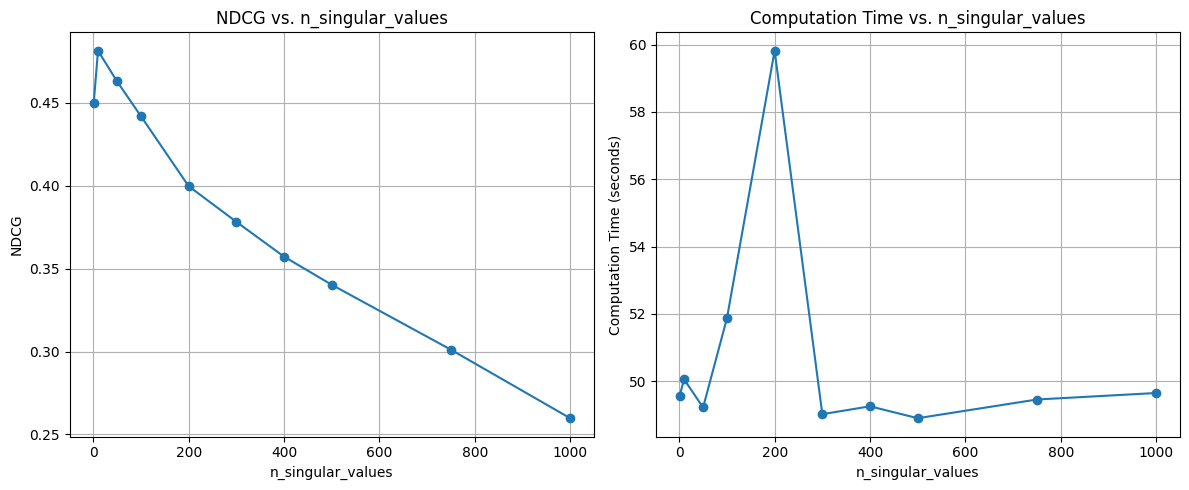

In [23]:
plot_graphs(coo_interactions, df_test, 100)

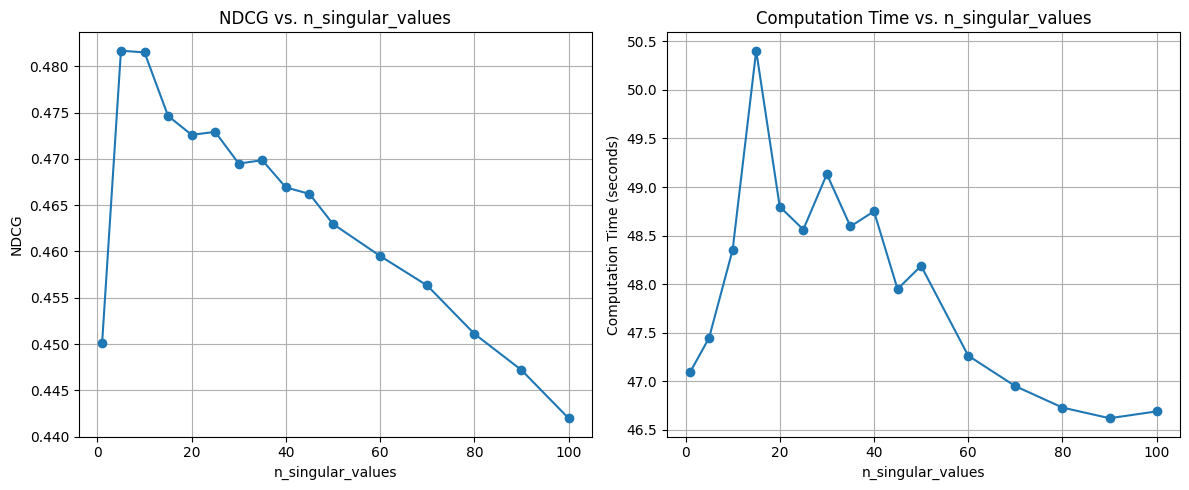

In [32]:
plot_graphs(coo_interactions, df_test, 100, [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100])


##### Задание 3.1. Перейдем к [ALS](http://yifanhu.net/PUB/cf.pdf). Возьмем реализацию iALS из библиотеки [implicit](https://benfred.github.io/implicit/api/models/cpu/als.html). Обучите ALS на нашем датасете, сделайте top_k рекомендации для юзеров из тестового датасета, и сравните метрики ALS с метриками, которые получились в SVD. Попробуйте перебрать гиперпараметры и найдите оптимальное число факторов, коэффициент alpha и коэффициент регуляризации.

In [23]:
!pip install implicit==0.6.2

In [24]:
import numpy as np
import implicit
from scipy.sparse import coo_matrix

def make_als_recommendations(
    interactions: Union[np.ndarray, coo_matrix],
    top_k: int = 100,
    n_factors: int = 100,
    alpha: float = 1.0,
    regularization: float = 0.01,
):
    if isinstance(interactions, np.ndarray):
        interactions = coo_matrix(interactions)

    model = implicit.als.AlternatingLeastSquares(
        factors=n_factors,
        regularization=regularization,
        alpha=alpha,
        iterations=20,
        use_gpu=False
    )

    model.fit(interactions)

    user_factors = model.user_factors
    item_factors = model.item_factors

    predictions = user_factors @ item_factors.T

    recommendations = np.argsort(-predictions, axis=1)[:, :top_k]

    return recommendations

In [27]:
recs = make_als_recommendations(interactions)
assert recs.shape == (interactions.shape[0], 100)

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.005788564682006836 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

In [25]:
import time
import matplotlib.pyplot as plt

def plot_graphs_als(interactions: coo_array, df_test: pd.DataFrame, top_k: int = 100, alpha: float = 1.0, regularization: float = 0.01):
    n_factors = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]
    times = []
    ndcg_scores = []

    for n_factor in n_factors:
        start_time = time.time()
        recs = make_als_recommendations(interactions, top_k, n_factor, alpha, regularization)
        end_time = time.time()
        times.append(end_time - start_time)

        y_true_all = []
        y_score_all = []

        for user_id in range(interactions.shape[0]):
            user_test_data = df_test[df_test['user_id'] == user_id]
            true_items = user_test_data['item_id'].tolist()
            true_ratings = user_test_data['rating'].tolist()

            if not true_items:
                continue

            y_true = []
            y_score = []
            for recommended_item_idx in recs[user_id]:
                if recommended_item_idx in true_items:
                    rating = true_ratings[true_items.index(recommended_item_idx)]
                    y_true.append(rating)
                    y_score.append(rating)
                else:
                    y_true.append(0)
                    y_score.append(0)

            if not y_true:
                continue

            y_true_all.append(y_true)
            y_score_all.append(y_score)

        ndcg = average_ndcg(y_true_all, y_score_all, k=top_k)
        ndcg_scores.append(ndcg)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(n_factors, ndcg_scores, marker='o')
    plt.xlabel("n_factors")
    plt.ylabel("NDCG")
    plt.title("NDCG vs. n_factors")
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(n_factors, times, marker='o')
    plt.xlabel("n_factors")
    plt.ylabel("Computation Time (seconds)")
    plt.title("Computation Time vs. n_factors")
    plt.grid(True)

    plt.tight_layout()
    plt.show()


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_array instead. Converting to CSR took 0.038881778717041016 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_array instead. Converting to CSR took 0.036983489990234375 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_array instead. Converting to CSR took 0.037784576416015625 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_array instead. Converting to CSR took 0.139312744140625 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_array instead. Converting to CSR took 0.03632783889770508 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_array instead. Converting to CSR took 0.03636908531188965 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_array instead. Converting to CSR took 0.036208391189575195 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_array instead. Converting to CSR took 0.03622746467590332 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_array instead. Converting to CSR took 0.03612232208251953 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_array instead. Converting to CSR took 0.04297637939453125 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_array instead. Converting to CSR took 0.036661386489868164 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_array instead. Converting to CSR took 0.036925315856933594 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_array instead. Converting to CSR took 0.049219608306884766 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_array instead. Converting to CSR took 0.03618931770324707 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_array instead. Converting to CSR took 0.03626441955566406 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_array instead. Converting to CSR took 0.0362856388092041 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

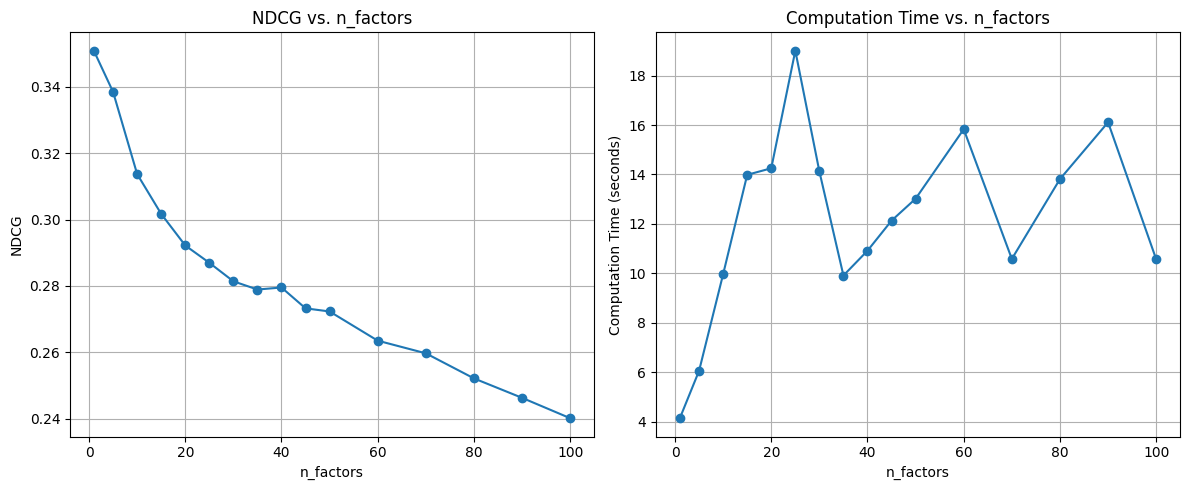

In [27]:
plot_graphs_als(coo_interactions, df_test)


Красиво, но хуже, чем свд, явно надо перебрать гиперпараметры, попробуем это сделать ниже

In [28]:
def best_score_als(interactions: coo_array, df_test: pd.DataFrame, top_k: int = 100):
    best_score_params = {}
    best_score = 0
    n_factors = [1, 5, 10, 20, 35, 50, 75, 100]
    alphas = [0.1, 0.5, 1.0]
    regularizations = [0.1, 1.0, 10.0]

    for n_factor in n_factors:
        for alpha in alphas:
            for regularization in regularizations:
                start_time = time.time()
                recs = make_als_recommendations(interactions, top_k, n_factor, alpha, regularization)

                y_true_all = []
                y_score_all = []

                for user_id in range(interactions.shape[0]):
                    user_test_data = df_test[df_test['user_id'] == user_id]
                    true_items = user_test_data['item_id'].tolist()
                    true_ratings = user_test_data['rating'].tolist()

                    if not true_items:
                        continue

                    y_true = []
                    y_score = []
                    for recommended_item_idx in recs[user_id]:
                        if recommended_item_idx in true_items:
                            rating = true_ratings[true_items.index(recommended_item_idx)]
                            y_true.append(rating)
                            y_score.append(rating)
                        else:
                            y_true.append(0)
                            y_score.append(0)

                    if not y_true:
                        continue

                    y_true_all.append(y_true)
                    y_score_all.append(y_score)

                ndcg = average_ndcg(y_true_all, y_score_all, k=top_k)
                if ndcg > best_score:
                    best_score = ndcg
                    best_score_params['n_factors'] = n_factor
                    best_score_params['alpha'] = alpha
                    best_score_params['regularization'] = regularization

    return best_score, best_score_params

print(best_score_als(coo_interactions, df_test))

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_array instead. Converting to CSR took 0.039234161376953125 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_array instead. Converting to CSR took 0.045949459075927734 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_array instead. Converting to CSR took 0.03653717041015625 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_array instead. Converting to CSR took 0.03619194030761719 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_array instead. Converting to CSR took 0.03586316108703613 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_array instead. Converting to CSR took 0.03679656982421875 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_array instead. Converting to CSR took 0.03685450553894043 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_array instead. Converting to CSR took 0.03639507293701172 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_array instead. Converting to CSR took 0.03613638877868652 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_array instead. Converting to CSR took 0.03721308708190918 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_array instead. Converting to CSR took 0.03626894950866699 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_array instead. Converting to CSR took 0.04548358917236328 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_array instead. Converting to CSR took 0.036623239517211914 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_array instead. Converting to CSR took 0.036753177642822266 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_array instead. Converting to CSR took 0.04096794128417969 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_array instead. Converting to CSR took 0.03660869598388672 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_array instead. Converting to CSR took 0.03641366958618164 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_array instead. Converting to CSR took 0.03605985641479492 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_array instead. Converting to CSR took 0.03889155387878418 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_array instead. Converting to CSR took 0.0362849235534668 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_array instead. Converting to CSR took 0.03608870506286621 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_array instead. Converting to CSR took 0.05283951759338379 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_array instead. Converting to CSR took 0.052872419357299805 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_array instead. Converting to CSR took 0.03673911094665527 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_array instead. Converting to CSR took 0.03607678413391113 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_array instead. Converting to CSR took 0.03631711006164551 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_array instead. Converting to CSR took 0.036318302154541016 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_array instead. Converting to CSR took 0.0361018180847168 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_array instead. Converting to CSR took 0.036113739013671875 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_array instead. Converting to CSR took 0.03673720359802246 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_array instead. Converting to CSR took 0.04868626594543457 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_array instead. Converting to CSR took 0.036902427673339844 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_array instead. Converting to CSR took 0.03701305389404297 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_array instead. Converting to CSR took 0.036452293395996094 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_array instead. Converting to CSR took 0.03709292411804199 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_array instead. Converting to CSR took 0.04819512367248535 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_array instead. Converting to CSR took 0.0364069938659668 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_array instead. Converting to CSR took 0.03607630729675293 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_array instead. Converting to CSR took 0.03785395622253418 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_array instead. Converting to CSR took 0.036954641342163086 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_array instead. Converting to CSR took 0.03634786605834961 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_array instead. Converting to CSR took 0.03612351417541504 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_array instead. Converting to CSR took 0.03659224510192871 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_array instead. Converting to CSR took 0.03913259506225586 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_array instead. Converting to CSR took 0.03919267654418945 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_array instead. Converting to CSR took 0.03643798828125 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_array instead. Converting to CSR took 0.03754281997680664 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_array instead. Converting to CSR took 0.03737044334411621 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_array instead. Converting to CSR took 0.0370335578918457 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_array instead. Converting to CSR took 0.04615163803100586 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_array instead. Converting to CSR took 0.03647184371948242 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_array instead. Converting to CSR took 0.03594970703125 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_array instead. Converting to CSR took 0.04525423049926758 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_array instead. Converting to CSR took 0.039498090744018555 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_array instead. Converting to CSR took 0.036802053451538086 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_array instead. Converting to CSR took 0.04640531539916992 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_array instead. Converting to CSR took 0.03640913963317871 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_array instead. Converting to CSR took 0.03638768196105957 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_array instead. Converting to CSR took 0.03616738319396973 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_array instead. Converting to CSR took 0.035941123962402344 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_array instead. Converting to CSR took 0.0362398624420166 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_array instead. Converting to CSR took 0.037187814712524414 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_array instead. Converting to CSR took 0.04612398147583008 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_array instead. Converting to CSR took 0.037008047103881836 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_array instead. Converting to CSR took 0.0361943244934082 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_array instead. Converting to CSR took 0.03593707084655762 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_array instead. Converting to CSR took 0.047041893005371094 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_array instead. Converting to CSR took 0.04315805435180664 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_array instead. Converting to CSR took 0.03626561164855957 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_array instead. Converting to CSR took 0.03728938102722168 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_array instead. Converting to CSR took 0.036232948303222656 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_array instead. Converting to CSR took 0.04649806022644043 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

(0.3508378760875593, {'n_factors': 1, 'alpha': 1.0, 'regularization': 10.0})


##### Задание 3.2. Сделайте объяснение рекомендаций для нескольких юзеров(als.explain). Воспользуйтесь файлом movies.dat чтобы перейти от индексов фильмов к их названием

In [68]:
import implicit
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix

movies_df = pd.read_csv('ml-1m/movies.dat', sep='::', names=['movie_id', 'title', 'genres'], engine='python', encoding='latin-1')

all_movie_ids = np.concatenate([df_train['item_id'].unique(), movies_df['movie_id'].unique()])

item_le.fit(all_movie_ids)

movies_df['movie_id'] = item_le.transform(movies_df['movie_id'])

movie_id_to_title = movies_df.set_index('movie_id')['title'].to_dict()

model = implicit.als.AlternatingLeastSquares(factors=100, regularization=0.01, alpha=1.0)

model.fit(coo_interactions)

user_id = 0

coo_interactions_csr = csr_matrix(coo_interactions)

recommendations = model.recommend(user_id, coo_interactions_csr[user_id], N=10)

recommended_item_ids = recommendations[0]
scores = recommendations[1]

for movie_id, score in zip(recommended_item_ids, scores):
    explanation = model.explain(user_id, coo_interactions_csr[user_id], itemid=movie_id)

    print(f"Recommendation for user {user_id}: {movie_id_to_title.get(movie_id, 'Unknown Movie')} (score: {score:.4f})")

    print("Explanation:")
    for contributing_item_id, contribution in explanation[1]:
        print(f"  - {movie_id_to_title.get(contributing_item_id, 'Unknown Movie')}: {contribution:.4f}")
    print("\n")

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_array instead. Converting to CSR took 0.03635454177856445 seconds
  warnings.warn(


  0%|          | 0/15 [00:00<?, ?it/s]

Recommendation for user 0: World of Apu, The (Apur Sansar) (1959) (score: 0.9053)
Explanation:
  - All Things Fair (1996): 0.1828
  - Maximum Overdrive (1986): 0.1132
  - Barbarella (1968): 0.1121
  - It's My Party (1995): 0.0782
  - Clean Slate (Coup de Torchon) (1981): 0.0741
  - Philadelphia Story, The (1940): 0.0740
  - Tarantella (1995): 0.0516
  - Broken Arrow (1996): 0.0422
  - Mrs. Winterbourne (1996): 0.0381
  - Poetic Justice (1993): 0.0358


Recommendation for user 0: Windows (1980) (score: 0.8209)
Explanation:
  - Mighty Peking Man (Hsing hsing wang) (1977): 0.1280
  - Foreign Correspondent (1940): 0.0880
  - Chasing Amy (1997): 0.0727
  - Mrs. Winterbourne (1996): 0.0635
  - Halloween: The Curse of Michael Myers (1995): 0.0487
  - Country Life (1994): 0.0374
  - Tarantella (1995): 0.0327
  - Lucie Aubrac (1997): 0.0296
  - All Things Fair (1996): 0.0271
  - Echte Kerle (1996): 0.0267


Recommendation for user 0: Princess Caraboo (1994) (score: 0.7761)
Explanation:
  - Flir

##### Задание 4. До этого мы работали с рейтингами, но как обсуждалось на лекции, implicit ALS отлично работает и с implicit фидбэком. Давайте попробуем преобразовать наш датасет(трейн и тест) следующим образом

1. Бинаризуем все рейтинги(заменим любую интеракцию пользователя на 1)
2. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на 0
3. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на -1
4. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на -1 и добавим сглаживание по времени. То есть чем дальше была интеракция от максимальной даты трейна, тем с меньшим весом мы будем ее учитывать(например можно интеракции за последний месяц брать в исходном виде, и с каждым месяцем в прошлое умножать их на какой-нибудь коэффициент меньший 1). Таким образом более старые интеракции пользователя будут вносить меньший вклад в его интересы
5. Придумайте свой вариант(опционально)

Для каждой полученной матрицы обучите iALS и SVD и сравните их результаты между собой(преобразовывать нужно только обучающую выборку, тестовую оставляем неизменной)

In [29]:
def binarize_ratings(df):
    """Заменяет все рейтинги на 1."""
    df_copy = df.copy()
    df_copy['rating'] = 1
    return df_copy

def replace_below_four_with_zero(df):
    """Заменяет рейтинги 4 и 5 на 1, остальные на 0."""
    df_copy = df.copy()
    df_copy['rating'] = df_copy['rating'].apply(lambda x: 1 if x >= 4 else 0)
    return df_copy

def replace_below_four_with_minus_one(df):
    """Заменяет рейтинги 4 и 5 на 1, остальные на -1."""
    df_copy = df.copy()
    df_copy['rating'] = df_copy['rating'].apply(lambda x: 1 if x >= 4 else -1)
    return df_copy

def time_decay(df, decay_factor=0.9, time_unit='M'):
    """Заменяет рейтинги 4 и 5 на 1, остальные на -1, и применяет временное сглаживание."""
    df_copy = df.copy()
    df_copy['rating'] = df_copy['rating'].apply(lambda x: 1 if x >= 4 else -1)

    max_date = df_copy['datetime'].max()
    df_copy['time_diff'] = (max_date - df_copy['datetime']) / np.timedelta64(1, 'D')
    df_copy['time_weight'] = decay_factor ** df_copy['time_diff']
    df_copy['rating'] = df_copy['rating'] * df_copy['time_weight']
    df_copy.drop(['time_diff', 'time_weight'], axis=1, inplace=True)

    return df_copy

def custom_transformation(df):
    """Пример собственного преобразования: взвешивание по рейтингу и времени."""
    df_copy = df.copy()
    max_date = df_copy['datetime'].max()
    time_diff_days = (max_date - df_copy['datetime']).dt.days
    time_weight = np.exp(-time_diff_days / 30)

    df_copy['rating'] = df_copy['rating'] * time_weight
    return df_copy

In [30]:
train_transformed = {}

train_transformed['binarized'] = binarize_ratings(df_train)
train_transformed['zero_below_four'] = replace_below_four_with_zero(df_train)
train_transformed['minus_one_below_four'] = replace_below_four_with_minus_one(df_train)
train_transformed['time_decay'] = time_decay(df_train)
train_transformed['custom'] = custom_transformation(df_train)

In [31]:
def train_and_evaluate(df_train_transformed, df_test):
    results = {}
    for name, df_train in df_train_transformed.items():
        interactions = df_to_coo(df_train)

        recs_als = make_als_recommendations(interactions)
        y_true_all, y_score_all = get_true_and_predicted_ratings(df_test, recs_als)
        ndcg_als = average_ndcg(y_true_all, y_score_all)
        results[name + '_als'] = ndcg_als

        recs_svd = make_svd_recommendations(interactions)
        y_true_all, y_score_all = get_true_and_predicted_ratings(df_test, recs_svd)
        ndcg_svd = average_ndcg(y_true_all, y_score_all)
        results[name + '_svd'] = ndcg_svd

    return results

In [32]:
def get_true_and_predicted_ratings(df_test, recommendations):
    y_true_all = []
    y_score_all = []

    for user_id in range(recommendations.shape[0]):
        user_test_data = df_test[df_test['user_id'] == user_id]
        true_items = user_test_data['item_id'].tolist()
        true_ratings = user_test_data['rating'].tolist()

        if not true_items:
            continue

        y_true = []
        y_score = []
        for recommended_item_idx in recommendations[user_id]:
            if recommended_item_idx in true_items:
                rating = true_ratings[true_items.index(recommended_item_idx)]
                y_true.append(rating)
                y_score.append(rating)
            else:
                y_true.append(0)
                y_score.append(0)

        if not y_true:
            continue

        y_true_all.append(y_true)
        y_score_all.append(y_score)

    return y_true_all, y_score_all

In [33]:
results = train_and_evaluate(train_transformed, df_test)

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_array instead. Converting to CSR took 0.0370025634765625 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_array instead. Converting to CSR took 0.03954720497131348 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_array instead. Converting to CSR took 0.03608441352844238 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_array instead. Converting to CSR took 0.04941558837890625 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_array instead. Converting to CSR took 0.03780221939086914 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

In [34]:
for name, metrics in results.items():
    print(f"{name}: {metrics:.6f}")

binarized_als: 0.016424
binarized_svd: 0.084897
zero_below_four_als: 0.013241
zero_below_four_svd: 0.084897
minus_one_below_four_als: 0.013846
minus_one_below_four_svd: 0.084897
time_decay_als: 0.023571
time_decay_svd: 0.084897
custom_als: 0.028707
custom_svd: 0.084897


Свд везде лучше, но вероятно из-за плохого подбора параметров в алс, при этом наш кастомный алс показывает себя лучше всего

##### Задание 5. iALS на numpy/torch. Давайте реализуем алгоритм iALS на нумпае или торче. Требуется реализовать алгорит, описанный в 4 части [статьи](http://yifanhu.net/PUB/cf.pdf). Обратите внимания на все оптимизации, которые они описывают в статье, чтобы сократить лишние вычисления. Hint: метрики у вашего алгоритма должны быть сравнимы с метриками ALS из библиотеки implicit

In [14]:
import numpy as np
import scipy.sparse as sp

def train_ials(R, num_factors=100, lambda_reg=0.1, alpha=40, iterations=10):
    num_users, num_items = R.shape

    X = np.random.normal(scale=0.01, size=(num_users, num_factors))
    Y = np.random.normal(scale=0.01, size=(num_items, num_factors))

    regI = lambda_reg * np.eye(num_factors)
    R_T = R.T.tocsr()

    for it in range(iterations):
        YtY = Y.T.dot(Y)
        for u in range(num_users):
            start_ptr, end_ptr = R.indptr[u], R.indptr[u+1]
            indices = R.indices[start_ptr:end_ptr]
            if len(indices) > 0:
                Y_u = Y[indices]
                confidences = 1 + alpha * R.data[start_ptr:end_ptr]
                A = YtY + (Y_u.T * (confidences - 1)).dot(Y_u)
                b = (Y_u.T).dot(confidences)
            else:
                A = YtY.copy()
                b = np.zeros(num_factors)
            A += regI
            X[u] = np.linalg.solve(A, b)

        XtX = X.T.dot(X)
        for i in range(num_items):
            start_ptr, end_ptr = R_T.indptr[i], R_T.indptr[i+1]
            indices = R_T.indices[start_ptr:end_ptr]
            if len(indices) > 0:
                X_i = X[indices]
                confidences = 1 + alpha * R_T.data[start_ptr:end_ptr]
                A = XtX + (X_i.T * (confidences - 1)).dot(X_i)
                b = (X_i.T).dot(confidences)
            else:
                A = XtX.copy()
                b = np.zeros(num_factors)
            A += regI
            Y[i] = np.linalg.solve(A, b)

        print(f"Iteration {it + 1} completed")

    return X, Y


X, Y = train_ials(coo_interactions.tocsr(), num_factors=10, lambda_reg=0.1, alpha=40, iterations=10)

scores = X[0].dot(Y.T)
print("Scores for user 0:", scores)


Iteration 1 completed
Iteration 2 completed
Iteration 3 completed
Iteration 4 completed
Iteration 5 completed
Iteration 6 completed
Iteration 7 completed
Iteration 8 completed
Iteration 9 completed
Iteration 10 completed
Scores for user 0: [0.88836528 0.309006   0.74844134 ... 0.67572135 0.73855982 0.84505163]


Метрика получилась даже лучше) Из-за альфы